## RNN

In [1]:
%run metrics.py

In [97]:
# utilities
import pandas as pd
import numpy as np
import os 
from tqdm import tqdm

# Processing
from sklearn.model_selection import train_test_split

# algorithms
from tensorflow import keras

# plotting
import matplotlib.pyplot as plt

# Setting the seed
import random
import tensorflow as tf

np.random.seed(490)
os.environ['PYTHONHASHSEED'] = '0'
random.seed(490)
tf.random.set_seed(490)

In [12]:
df = pd.read_csv('sp500.csv',
                parse_dates = ['Date'],
                index_col = 'Date')

In [12]:
print(df.head(1), '\n')
print(df.tail(1), '\n')
print(df.shape)

               Open     High      Low    Close
Date                                          
2021-03-26  3917.12  3978.19  3917.12  3974.54 

             Open   High    Low  Close
Date                                  
1927-12-30  17.66  17.66  17.66  17.66 

(23420, 4)


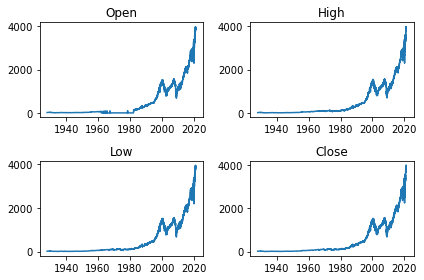

In [104]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)

for i in range(df.shape[1]):
    plt.subplot(2, 2, i + 1)
    plt.plot(df.iloc[:, i])
    plt.title(df.columns[i])
    
plt.tight_layout()

In [109]:
8.273112 - 8.263420	

0.009691999999999368

In [113]:
df2 = df.sort_index().apply(np.log, axis = 0).diff().dropna()
df2

,Open,High,Low,Close
Date,,,,
1928-01-03,0.005647,0.005647,0.005647,0.005647
1928-01-04,-0.002255,-0.002255,-0.002255,-0.002255
1928-01-05,-0.009640,-0.009640,-0.009640,-0.009640
1928-01-06,0.006248,0.006248,0.006248,0.006248
1928-01-09,-0.009101,-0.009101,-0.009101,-0.009101
...,...,...,...,...
2021-03-22,0.000853,0.006389,0.007027,0.007001
2021-03-23,0.005378,-0.001564,-0.003222,-0.007660
2021-03-24,-0.004498,-0.001787,-0.003209,-0.005482


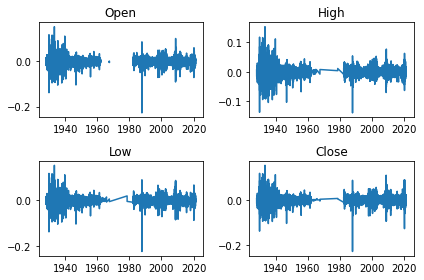

In [114]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)

for i in range(df2.shape[1]):
    plt.subplot(2, 2, i + 1)
    plt.plot(df2.iloc[:, i])
    plt.title(df2.columns[i])
    
plt.tight_layout()

In [115]:
n = df2.shape[0]
train_length = 20
pred_length = 5

In [116]:
train_end = np.arange(train_length, n - pred_length, train_length + pred_length)
train_end.shape

(734,)

In [117]:
df2.head(1)
y_index = np.where(df2.columns == 'Close')

In [119]:
# Creating the data set
x = np.empty(shape = (0, train_length, n_features))
y = np.empty(shape = (0, train_length, pred_length))

for i in tqdm(range(len(train_end))):
    data_stdz = df.iloc[(train_end[i] - train_length):(train_end[i] + pred_length)].to_numpy()
    
    x_next = data_stdz[:train_length, ]
    
    y_next = np.empty(shape = (train_length, pred_length))
    for step in range(pred_length):
        y_next[:, step] = data_stdz[(step + 1):(train_length + step + 1), y_index].reshape(train_length)

    x = np.concatenate((x, x_next[np.newaxis, ...]), axis = 0)
    y = np.concatenate((y, y_next[np.newaxis, ...]), axis = 0)

100%|██████████████████████████████████████████████████████████████████████████████| 734/734 [00:00<00:00, 6342.62it/s]


In [120]:
x.shape, y.shape

((734, 20, 4), (734, 20, 5))

# Sequence to Sequence

In [121]:
indx = range(x.shape[0])

In [122]:
i_train_full, i_test = train_test_split(indx,
                                       train_size = 0.85,
                                       random_state = 490)

In [123]:
len(i_train_full), len(i_test)

(623, 111)

In [124]:
i_train, i_valid = train_test_split(i_train_full,
                                   train_size = 0.85,
                                   random_state = 490)

In [125]:
len(i_train), len(i_valid), len(i_test)

(529, 94, 111)

## One Period Ahead

### t+1

In [126]:
x_train = x[i_train, ...]
y_train = y[i_train, :, 0]

x_valid = x[i_valid, ...]
y_valid = y[i_valid, :, 0]

x_test  = x[i_test, ...]
y_test  = y[i_test, :, 0]

### t+3

In [127]:
x_train = x[i_train, ...]
y_train = y[i_train, :, 2]

x_valid = x[i_valid, ...]
y_valid = y[i_valid, :, 2]

x_test  = x[i_test, ...]
y_test  = y[i_test, :, 2]

*************
#### Baseline
[TOP](#RNN)

The baseline is to simply predict the future $y_{t+3}$ taking on the value of $y_t$.

In [128]:
yhat = x_test[:, -1, y_index]
y_true = y_test[:, -1]

rmse_base = rmse(yhat, y_true)
rmse_base

1120.5352067597294

*************
#### Simple RNN
[TOP](#RNN)


In [129]:
model = keras.models.Sequential([
#     keras.layers.SimpleRNN(20, 
#                            input_shape = [train_length, n_features],
#                            return_sequences = True)
    keras.layers.SimpleRNN(20, 
                           return_sequences = True,
                          input_shape = [None, n_features]),
    keras.layers.Dense(1)
])

model.compile(loss = 'mse', 
              optimizer = keras.optimizers.SGD(learning_rate = 1e-10))
history = model.fit(x_train, y_train,
                   epochs = 20,
                   validation_data = (x_valid, y_valid))

Epoch 1/20
17/17 [==============================] - 0s 11ms/step - loss: 1064609.1250 - val_loss: 897244.3125
Epoch 2/20
17/17 [==============================] - 0s 3ms/step - loss: 1064608.8750 - val_loss: 897244.0625
Epoch 3/20
17/17 [==============================] - 0s 3ms/step - loss: 1064608.6250 - val_loss: 897243.9375
Epoch 4/20
17/17 [==============================] - 0s 2ms/step - loss: 1064608.5000 - val_loss: 897243.7500
Epoch 5/20
17/17 [==============================] - 0s 3ms/step - loss: 1064608.2500 - val_loss: 897243.5625
Epoch 6/20
17/17 [==============================] - 0s 2ms/step - loss: 1064608.0000 - val_loss: 897243.3750
Epoch 7/20
17/17 [==============================] - ETA: 0s - loss: 1911197.375 - 0s 3ms/step - loss: 1064607.7500 - val_loss: 897243.0625
Epoch 8/20
17/17 [==============================] - 0s 2ms/step - loss: 1064607.6250 - val_loss: 897242.8750
Epoch 9/20
17/17 [==============================] - 0s 3ms/step - loss: 1064607.2500 - val_loss: 

In [81]:

x_train

array([[[ 0.18194179,  0.18194179,  0.18194179,  0.18194179],
        [ 0.30487543,  0.30487543,  0.30487543,  0.30487543],
        [ 0.42780907,  0.42780907,  0.42780907,  0.42780907],
        ...,
        [-1.04739462, -1.04739462, -1.04739462, -1.04739462],
        [-1.04739462, -1.04739462, -1.04739462, -1.04739462],
        [-1.41619555, -1.41619555, -1.41619555, -1.41619555]],

       [[ 0.94483745,  0.82632474,  1.18150203,  1.03464947],
        [ 0.24113397,  0.9581927 ,  0.71912727,  0.94452786],
        [ 0.80620918,  0.36837027,  0.52829601,  0.0860361 ],
        ...,
        [ 0.7798038 ,  0.29813625,  0.24298763, -0.08753145],
        [ 0.88608547,  0.41352071,  0.74165162,  0.80700897],
        [-0.24538523,  0.69660681,  0.25800386,  0.98658462]],

       [[ 1.32581006,  1.84996289,  1.62091908,  2.04012063],
        [ 1.23530199,  1.10973206,  1.40319993,  1.13901879],
        [ 0.69363183,  1.17069224,  0.97526919,  1.07152924],
        ...,
        [-0.76184827, -0.39